# Fashion MNIST Classification: Vision Transformer

## Table of Contents
- Setup
- Configuration
- Helpers
- Import and preprcess dataset
- Model Development


## Setup

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras import layers

## Configuration

In [2]:
class Config:
    # Origin image size
    input_size = 28
    # Input shape of image
    input_shape = [input_size, input_size, 1]
    # Learning rate of the Model
    learning_rate = 0.001
    # Weight decay rate of the Model
    weight_decay = 0.0001
    # Batch size of the Model
    batch_size = 256
    num_classes = 10
    num_epochs = 30
    image_size = 72
    patch_size = 6
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 64
    num_heads = 4
    transformer_units = [
        projection_dim * 2,
        projection_dim
    ]
    transformer_layers = 8
    mlp_head_units = [2048, 1024]

## Helpers

### Sample Images

In [3]:
def sample_images(images, row_count, column_count):
    fig, axs = plt.subplots(row_count, column_count, figsize=(10,10))
    for i in range(row_count):
        for j in range(column_count):
            axs[i,j].imshow(images[i * column_count + j])
            axs[i,j].axis('off')
    plt.show()

## Import and preprcess dataset

In [4]:
train = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_train.csv")
test = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_test.csv")
train_labels = train.pop("label")
test_labels = test.pop("label")

In [5]:
train = np.array(train).reshape((-1, Config.input_size, Config.input_size, 1))
test = np.array(test).reshape((-1, Config.input_size, Config.input_size, 1))

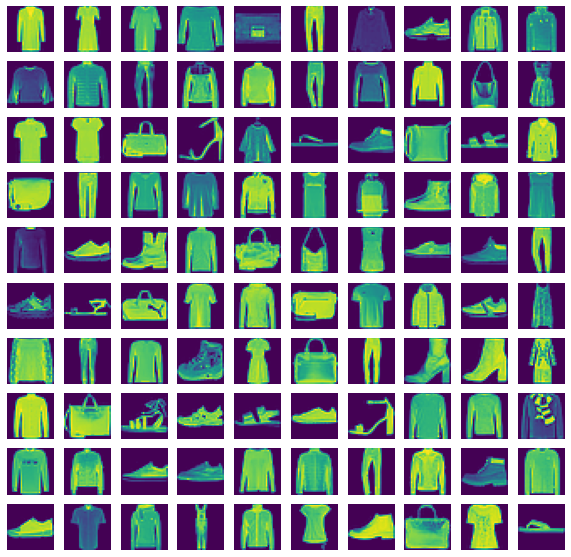

In [6]:
indices = np.random.choice(train.shape[0], 100)
sample_images(train[indices].squeeze(), 10, 10)

## Model Development

### Data Augmentation

In [7]:
augmentation_layer = tf.keras.Sequential([
    keras.layers.Input(Config.input_shape),
    keras.layers.experimental.preprocessing.Normalization(),
    keras.layers.experimental.preprocessing.Resizing(Config.image_size, Config.image_size),
    keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
    keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
])

### MLP

In [8]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

### Patches Creation Layer
This Layer can convert image to N x N Grid.

In [9]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

(256, 72, 72, 1)
Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 36


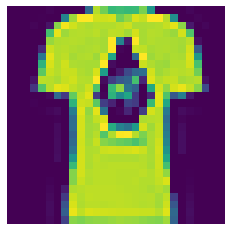

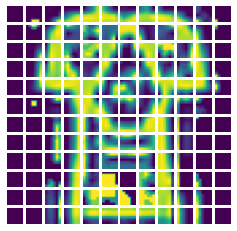

In [10]:

plt.figure(figsize=(4, 4))
start_index = np.random.choice(train.shape[0] // 2)
image = train[start_index: start_index + Config.batch_size]
plt.imshow(np.squeeze(image[0]).astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor(image), size=(Config.image_size, Config.image_size)
)
print(resized_image.shape)
patches = Patches(Config.patch_size)(resized_image)
print(f"Image size: {Config.image_size} X {Config.image_size}")
print(f"Patch size: {Config.patch_size} X {Config.patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (Config.patch_size, Config.patch_size))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

### Patch Encoder Layer

In [11]:
class PatchEncoder(layers.Layer):
    
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded
        

### Build the Model

In [12]:
def create_vision_transformer():
    # Inputs
    inputs = layers.Input(shape=Config.input_shape)
    # Data Augmentation
    augmented = augmentation_layer(inputs)
    # Patches
    patches = Patches(Config.patch_size)(augmented)
    encoder_patches = PatchEncoder(Config.num_patches, Config.projection_dim)(patches)
    
    for _ in range(Config.transformer_layers):
        # Layer Normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
        # Multi-Head Attention Layer
        attention_output = layers.MultiHeadAttention(
            num_heads=Config.num_heads, 
            key_dim=Config.projection_dim,
            dropout=0.1
        )(x1, x1)
        # Skip Connnection 1
        x2 = attention_output + encoder_patches
        
        # Layer Normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # MLP
        x3 = mlp(x3, hidden_units=Config.transformer_units, dropout_rate=0.1)
        
        # Skip Connnection 2
        encoder_patches = x3 + x2
    
    representation = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    
    features = mlp(representation, hidden_units=Config.mlp_head_units, dropout_rate=0.5)
    
    outputs = layers.Dense(Config.num_classes)(features)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [13]:
keras.backend.clear_session()
vit_classifier = create_vision_transformer()
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 72, 72, 1)    3           input_1[0][0]                    
__________________________________________________________________________________________________
patches (Patches)               (None, None, 36)     0           sequential[0][0]                 
__________________________________________________________________________________________________
patch_encoder (PatchEncoder)    (None, 144, 64)      11584       patches[0][0]                    
______________________________________________________________________________________________

## Training

In [14]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr


optimizer = tfa.optimizers.AdamW(
    learning_rate=Config.learning_rate,
    weight_decay=Config.weight_decay
)

lr_metric = get_lr_metric(optimizer)

vit_classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=["accuracy", lr_metric]
)
checkpoint_path = "model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
)

In [15]:
history = vit_classifier.fit(train, train_labels, epochs=Config.num_epochs, batch_size=Config.batch_size, validation_data=(test, test_labels))

Epoch 1/30
235/235 [==============================] - 69s 249ms/step - loss: 1.8657 - accuracy: 0.5860 - lr: 0.0010 - val_loss: 0.5070 - val_accuracy: 0.8182 - val_lr: 1.0000e-03
Epoch 2/30
235/235 [==============================] - 57s 242ms/step - loss: 0.6114 - accuracy: 0.7693 - lr: 0.0010 - val_loss: 0.4567 - val_accuracy: 0.8253 - val_lr: 1.0000e-03
Epoch 3/30
235/235 [==============================] - 57s 242ms/step - loss: 0.5535 - accuracy: 0.7906 - lr: 0.0010 - val_loss: 0.4288 - val_accuracy: 0.8410 - val_lr: 1.0000e-03
Epoch 4/30
235/235 [==============================] - 57s 242ms/step - loss: 0.5306 - accuracy: 0.8029 - lr: 0.0010 - val_loss: 0.4161 - val_accuracy: 0.8532 - val_lr: 1.0000e-03
Epoch 5/30
235/235 [==============================] - 57s 243ms/step - loss: 0.4962 - accuracy: 0.8170 - lr: 0.0010 - val_loss: 0.4026 - val_accuracy: 0.8587 - val_lr: 1.0000e-03
Epoch 6/30
235/235 [==============================] - 57s 243ms/step - loss: 0.4761 - accuracy: 0.8211 - 

In [16]:
product = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
labels = [0,1,2,3,4,5,6,7,8,9]

In [17]:
#Making Prediction
y_prob = vit_classifier.predict(test)
y_pred = y_prob.argmax(axis=1)

In [18]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, product, rotation=45)
    plt.yticks(tick_marks, product)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Normalized confusion matrix


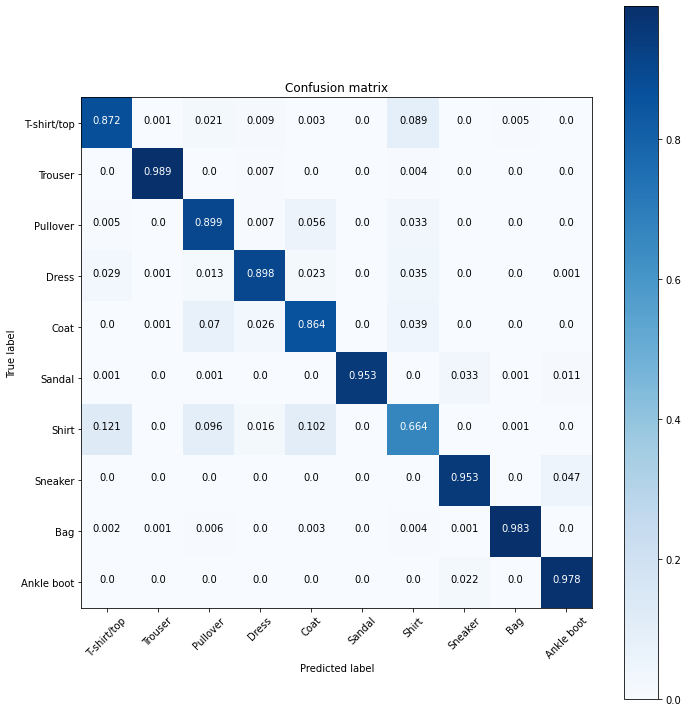

In [19]:
#Making the Confusion Matrix
confusionmatrix = np.around(confusion_matrix(test_labels, y_pred, normalize='true'),3)
plot_confusion_matrix(confusionmatrix, np.unique(train_labels))

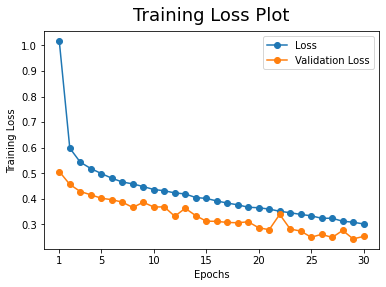

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming history.history['loss'] and history.history['val_loss'] are defined
plt.plot(range(len(history.history['loss'])), np.around(history.history['loss'], 4), marker='o')
plt.plot(range(len(history.history['val_loss'])), np.around(history.history['val_loss'], 4), marker='o')

# Set x-axis ticks and labels to only show specific epochs
plt.xticks(ticks=[0, 4, 9, 14, 19, 24, 29], labels=['1', '5', '10', '15', '20', '25', '30'])

# Setting the title, legend, and x and y labels
plt.title('Training Loss Plot', fontsize=18, y=1.02)
plt.legend(['Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Training Loss')

plt.show()


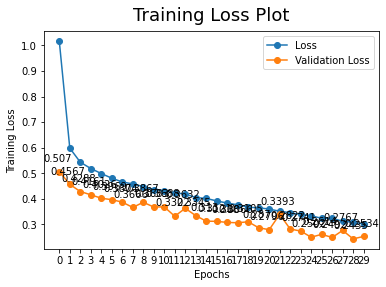

In [21]:
plt.plot(range(len(history.history['loss'])),np.around(history.history['loss'],4), marker='o' )
plt.plot(range(len(history.history['val_loss'])),np.around(history.history['val_loss'],4), marker='o' )

xpoints =  range(len(history.history['val_loss']))
ypoints =  np.around(history.history['val_loss'],4)

#Annotating
for x, y in zip(xpoints, ypoints):
    plt.annotate(y,xy=(x, y), xytext=(-2, 8),textcoords='offset points', ha='center', va='bottom')

#Setting the ticks, title, legend and x and y label
plt.xticks(ticks=range(len(history.history['loss'])))
plt.title('Training Loss Plot', fontsize=18, y=1.02)
plt.legend(['Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Training Loss')


plt.show()

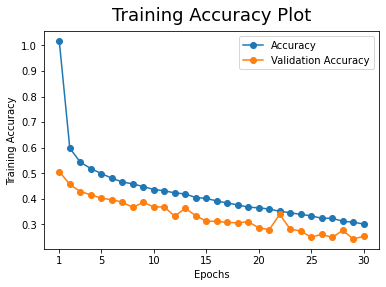

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming history.history['loss'] and history.history['val_loss'] are defined
plt.plot(range(len(history.history['loss'])), np.around(history.history['loss'], 4), marker='o')
plt.plot(range(len(history.history['val_loss'])), np.around(history.history['val_loss'], 4), marker='o')

# Set x-axis ticks and labels to only show specific epochs
plt.xticks(ticks=[0, 4, 9, 14, 19, 24, 29], labels=['1', '5', '10' ,'15', '20', '25', '30'])

# Setting the title, legend, and x and y labels
plt.title('Training Accuracy Plot', fontsize=18, y=1.02)
plt.legend(['Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.show()


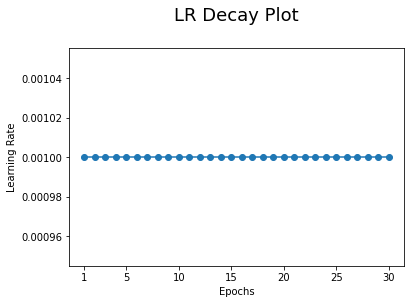

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming history.history['lr'] is defined and logged during training
plt.plot(range(len(history.history['lr'])), np.around(history.history['lr'], 4), marker='o')

# Set x-axis ticks and labels to only show specific epochs
plt.xticks(ticks=[0, 4, 9, 14, 19, 24, 29], labels=['1', '5', '10' ,'15', '20', '25', '30'])

# Setting the title, x and y labels
plt.title('LR Decay Plot', fontsize=18, y=1.1)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')

plt.show()


In [24]:
from sklearn.metrics import classification_report

#Getting the probablities
y_prob_train = vit_classifier.predict(train)
train_pred = y_prob_train.argmax(axis=1)
print('=== TEST CLASSIFICATION REPORT ===')
print(classification_report(test_labels, y_pred))

=== TEST CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1000
           1       1.00      0.99      0.99      1000
           2       0.81      0.90      0.85      1000
           3       0.93      0.90      0.91      1000
           4       0.82      0.86      0.84      1000
           5       1.00      0.95      0.98      1000
           6       0.76      0.66      0.71      1000
           7       0.94      0.95      0.95      1000
           8       0.99      0.98      0.99      1000
           9       0.94      0.98      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.90     10000
weighted avg       0.91      0.91      0.90     10000



In [25]:
tr_colors = ['blue', 'green', 'red', 'yellow', 'purple']

In [26]:
count = {int(value): list(train_labels[train_labels != train_pred]).count(value) for value in set(train_labels[train_labels != train_pred])}
maxvalue = max(count, key=count.get)

#Setting the color of the most misqualified labels to 'indianred'
tr_colors = {}
keys = range(len(np.unique(train_labels)))
for i in keys:
    for x in ['lightgray']:
        for j in ['red']:
            tr_colors[i] = x
            tr_colors[maxvalue] = j
print(tr_colors)

{0: 'lightgray', 6: 'red', 1: 'lightgray', 2: 'lightgray', 3: 'lightgray', 4: 'lightgray', 5: 'lightgray', 7: 'lightgray', 8: 'lightgray', 9: 'lightgray'}


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


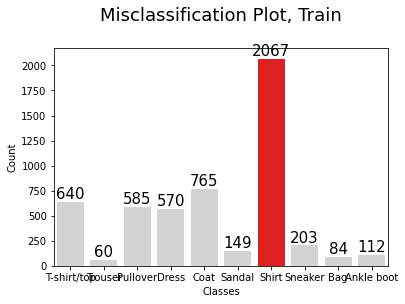

In [27]:
ax = sns.countplot(train_labels[train_labels != train_pred], palette=tr_colors)
plt.xticks(ticks=np.unique(train_labels), labels = product)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'),(bar.get_x() + bar.get_width() / 2,bar.get_height()), 
                 ha='center', va='center',size=15, xytext=(0, 8),textcoords='offset points')
plt.title('Misclassification Plot, Train', fontsize=18, y=1.1)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

In [28]:
count = {int(value): list(test_labels[test_labels != y_pred]).count(value) for value in set(test_labels[test_labels != y_pred])}
maxvalue = max(count, key=count.get)

#Setting the color of the most misqualified labels to 'indianred'
colors = {}
keys = range(len(np.unique(train_labels)))
for i in keys:
    for x in ['lightgray']:
        for j in ['red']:
            colors[i] = x
            colors[maxvalue] = j
print(colors)

{0: 'lightgray', 6: 'red', 1: 'lightgray', 2: 'lightgray', 3: 'lightgray', 4: 'lightgray', 5: 'lightgray', 7: 'lightgray', 8: 'lightgray', 9: 'lightgray'}


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


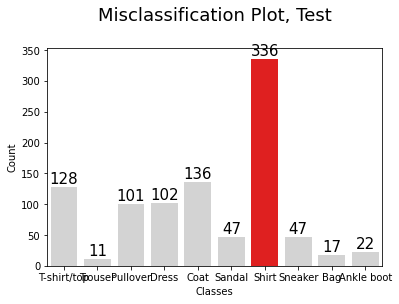

In [29]:
ax = sns.countplot(test_labels[test_labels != y_pred], palette=colors)
plt.xticks(ticks=np.unique(train_labels), labels = product)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'),(bar.get_x() + bar.get_width() / 2,bar.get_height()), 
                 ha='center', va='center',size=15, xytext=(0, 8),textcoords='offset points')
plt.title('Misclassification Plot, Test', fontsize=18, y=1.1)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()